# Ticket Reservation Insight Dashboard
## Introduction

### Business Overview
This database is designed to support an online ticket reservation system that efficiently manages multiple events across various venues. It provides a seamless booking experience for individual customers, corporate clients, and event organizers, integrating flexible pricing strategies and multiple payment options.

The system facilitates data-driven decision-making by offering insights into revenue trends, customer behavior, and venue performance to optimize business growth and profitability.


Database Schema :
![TicketReservationSystem Database](https://drive.google.com/uc?export=view&id=1Kgz6_C3RE8BVuTsobbw6lBmIu6FOhWiC)


Here is my database DDL file
[OnlineTicketReservationSystem MySQL DDL](https://drive.google.com/uc?export=view&id=1WcOPEZli7lINTukzF4Dzu1qoW0DoyEc8)


In [279]:
import sys
!pip install pandas
!pip install numpy
!pip install datapane
!pip install plotly
!pip install pymysql
!pip install mysql-connector-python

In [280]:
## Setup python system

In [281]:
# import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datapane as dp
import pymysql
import warnings
import pymysql
import sys
import os

warnings.filterwarnings('ignore')



In [282]:
host = 'database-mis686-tp.c7a2o0gm26x0.us-east-2.rds.amazonaws.com'
user = 'admin'
password = 'rememberM33!!!'
database = 'TicketReservationSystem'

connection = pymysql.connect(host=host, user=user, passwd=password, database=database)
with connection:
    cur = connection.cursor()
    cur.execute("SELECT VERSION()")
    version = cur.fetchone()
    print("Database version: {} ".format(version[0]))

Database version: 8.0.40 


In [283]:

def run_query(q: str) -> pd.DataFrame:
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        return pd.read_sql(q, conn)


def run_command(c: str):
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [284]:
def show_tables() -> pd.DataFrame:
    q = """
          SELECT table_name
          FROM information_schema.tables
          WHERE table_schema = 'TicketReservationSystem' AND table_type = 'BASE TABLE';
        """
    return run_query(q)


def get_table_row_count(tablename) -> int:
    q = (
        """
        SELECT
            COUNT(1)
        FROM %s;
        """
        % tablename
    )
    return run_query(q)["COUNT(1)"][0]


tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables['TABLE_NAME']]

tables

,TABLE_NAME,row_count
0,Booking,183
1,BookingSeat,183
2,CorporateCustomer,17
3,Discount,9
4,Event,79
5,EventVenue,77
6,IndividualCustomer,20
7,Organizer,20
8,Payment,178
9,Seat,168



## Building a dashboard

#### 1. Calculating Key Performance Indicator (KPIs Summary)
#### - Total Revenue : 
Displays the cumulative revenue generated from ticket sales
#### - Total Bookings : 
Shows the total number of reservations made
#### - Total Customer : 
Indicates the number of unique customers.

In [286]:
def get_total_revenue() -> float:
    """Fetches the total revenue from the Payment table."""
    query = "SELECT SUM(Amount) AS total_revenue FROM Payment;"
    return run_query(query)["total_revenue"][0] or 0

def get_total_bookings() -> int:
    """Fetches the total number of bookings."""
    query = "SELECT COUNT(*) AS total_bookings FROM Booking;"
    return run_query(query)["total_bookings"][0] or 0

def get_total_customers() -> int:
    """Fetches the total number of unique customers."""
    query = "SELECT COUNT(DISTINCT UserID) AS total_customers FROM Booking;"
    return run_query(query)["total_customers"][0] or 0


# Fetch the key metrics
total_revenue = get_total_revenue()
total_bookings = get_total_bookings()
total_customers = get_total_customers()


#### - Upcoming 10 Events : Lists the next ten scheduled events.

In [288]:
### Upcoming 10 Events
import datapane as dp

upcoming_event = """
SELECT 
    e.EventName, 
    v.VenueName, 
    e.Date 
FROM Event e
JOIN EventVenue ev ON e.EventID = ev.EventID
JOIN Venue v ON ev.VenueID = v.VenueID
WHERE e.Date >= CURDATE()
ORDER BY e.Date ASC
LIMIT 5

"""

upcoming_event_df = run_query(upcoming_event)

upcoming_event_df

,EventName,VenueName,Date
0,Chess Tournament,Rooftop Arena,2025-03-21
1,Chess Tournament,Grand Theater,2025-03-28
2,Chess Tournament,Conference Hall A,2025-04-04
3,Startup Pitch Night,Cultural Center,2025-04-15
4,Comedy Night,Banquet Hall,2025-05-10


#### 2. Revenue Analytics


#### - Revenue by Event : 
A bar chart illustrating each event's total revenue, sorted from highest to lowest.

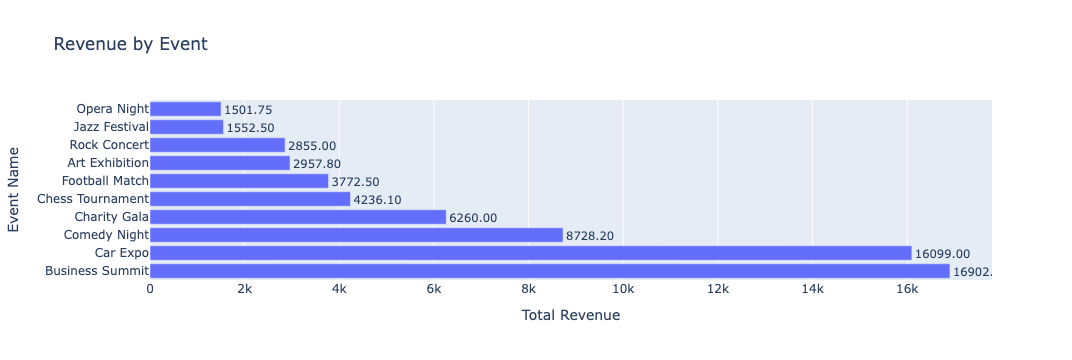

In [292]:

# Calculate Revenue by Event to show which events generate the most income
revenue_by_event = """
SELECT 
    E.EventName,
    SUM(P.Amount) AS TotalRevenue
FROM Payment P
JOIN Booking B ON P.BookingID = B.BookingID
JOIN Event E ON B.EventID = E.EventID
GROUP BY E.EventName
ORDER BY TotalRevenue DESC
LIMIT 10;

"""

revenue_by_event_df = run_query(revenue_by_event)

# Define dataframe
revenue_by_event_df.columns = ["Event Name", "Total Revenue"]

# Create the bar chart 
revenue_by_event_plot = px.bar(
    revenue_by_event_df, 
    x="Total Revenue",
    y="Event Name",
    orientation="h",
    text="Total Revenue", 
    title="Revenue by Event",
)

# Update text format
revenue_by_event_plot.update_traces(texttemplate="%{text:.2f}", textposition="outside")

# Show the plot
revenue_by_event_plot.show()

#### - Monthly Revenue Growth : 
revenue trends over time

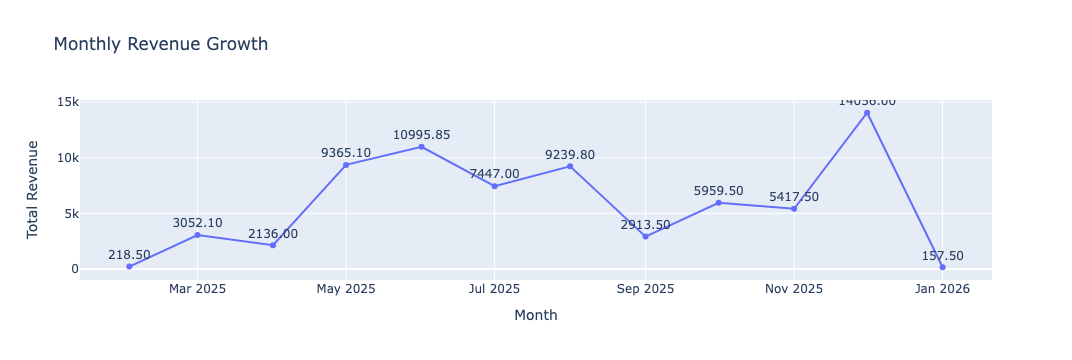

In [294]:
# Display monthly revenue growth

revenue_by_month = """
SELECT 
    DATE_FORMAT(P.PaymentDate, '%Y-%m') AS Month,
    SUM(P.Amount) AS TotalRevenue
FROM Payment P
GROUP BY Month
ORDER BY Month;

"""
revenue_by_month_df = run_query(revenue_by_month)

# Define dataframe
revenue_by_month_df.columns = ["Month", "Total Revenue"]

# Convert 'Month' to datetime for better plotting
revenue_by_month_df["Month"] = pd.to_datetime(revenue_by_month_df["Month"])

# Create the line chart 
revenue_by_month_plot = px.line(
    revenue_by_month_df,  
    x="Month",
    y="Total Revenue",
    text = "Total Revenue",
    title="Monthly Revenue Growth",
    markers=True
)

# Update text format
revenue_by_month_plot.update_traces(texttemplate="%{text:.2f}", textposition="top center")

# Show the plot
revenue_by_month_plot.show()

#### - Top Venue Generating Revenue : 
Highlights venues ranked by total revenue contribution.

In [296]:
top_venue = """
    SELECT 
        V.VenueName,
        SUM(P.Amount) AS TotalRevenue
    FROM Payment P
    JOIN Booking B ON P.BookingID = B.BookingID
    JOIN Event E ON B.EventID = E.EventID
    JOIN EventVenue EV ON E.EventID = EV.EventID
    JOIN Venue V ON EV.VenueID = V.VenueID
    GROUP BY V.VenueName
    ORDER BY TotalRevenue DESC
    LIMIT 10;
"""

# Fetch Data
top_venue_df = run_query(top_venue)

top_venue_df


,VenueName,TotalRevenue
0,Conference Hall A,8875.80
1,Music Hall,7445.10
2,Convention Center,7276.00
3,Opera House,4674.75
4,Expo Center,4614.00
5,Concert Hall B,4457.50
6,Banquet Hall,4397.50
7,Tech Convention Center,3985.50
8,Sports Stadium,3945.00
9,Art Gallery,3169.50


#### 3. Customer Behavior & Sales Analysis
#### - Ticket Sales by Seat Category : 
A pie chart showing the distribution of sales among VIP, Regular, and Economy seats.

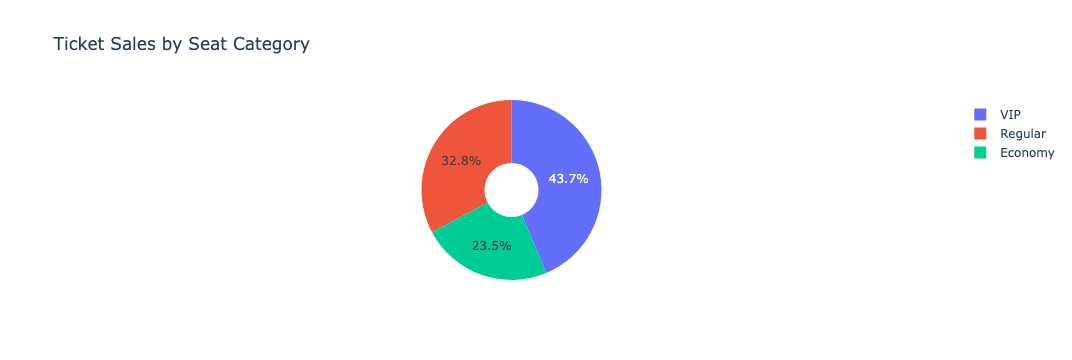

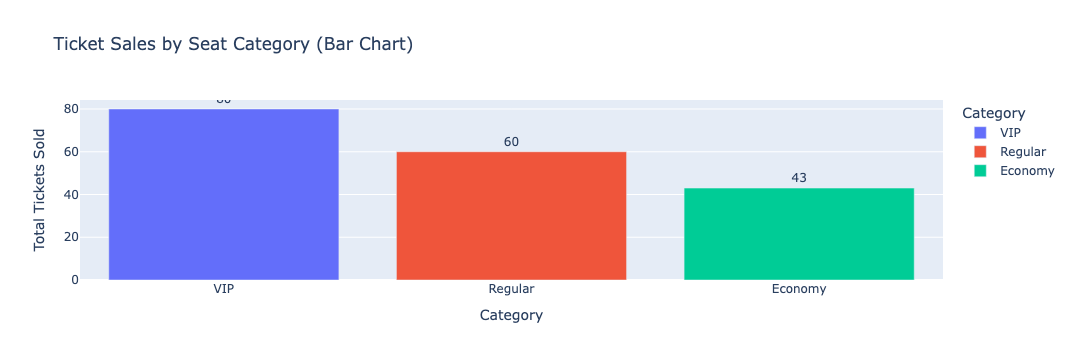

In [298]:
# Ticket Sales by Category
sales_category = """
    SELECT 
        S.Category,
        COUNT(BS.SeatID) AS TicketsSold
    FROM BookingSeat BS
    JOIN Seat S ON BS.SeatID = S.SeatID
    GROUP BY S.Category
    ORDER BY TicketsSold DESC;
"""

# Fetch Data
sales_category_df = run_query(sales_category)

# Rename columns
sales_category_df.columns = ["Category", "Tickets Sold"]

# 🔹 Pie Chart
sales_fig_pie = px.pie(
    sales_category_df,
    names="Category",
    values="Tickets Sold",
    title="Ticket Sales by Seat Category",
    hole=0.3  # Adjust for a donut chart effect
)

# Show Pie Chart
sales_fig_pie.show()

# 🔹 Bar Chart
sales_fig_bar = px.bar(
    sales_category_df,
    x="Category",
    y="Tickets Sold",
    text="Tickets Sold",
    title="Ticket Sales by Seat Category (Bar Chart)",
    color="Category"
)

# Format text labels and layout
sales_fig_bar.update_traces(texttemplate="%{text}", textposition="outside")
sales_fig_bar.update_layout(yaxis=dict(title="Total Tickets Sold"), xaxis=dict(title="Category"))

# Show Bar Chart
sales_fig_bar.show()

#### - User Type Distribution : 
A pie chart depicting the proportion of Individual Customers, Corporate Customers, and Organizers.

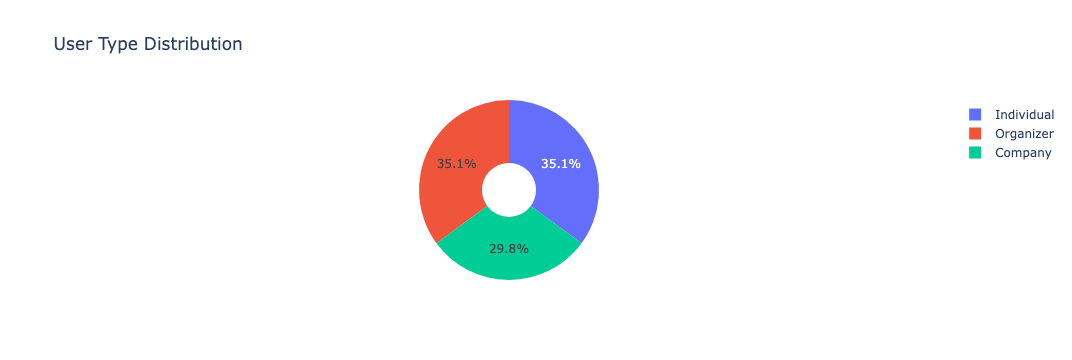

In [300]:
# User Type Distribution
user_type_distribution_query = """
SELECT 
    UserType,
    COUNT(*) AS UserCount
FROM User
GROUP BY UserType
ORDER BY UserCount DESC;
"""

# Fetch Data
user_type_df = run_query(user_type_distribution_query)

# Create Pie Chart
user_fig_pie = px.pie(
    user_type_df,
    names="UserType",
    values="UserCount",
    title="User Type Distribution",
    hole=0.3  # Adjust for a donut chart effect
)

# Show Pie Chart
user_fig_pie.show()

#### - Top Organizers by Revenue Percentage: 
Identifies which event organizers generate the most revenue.

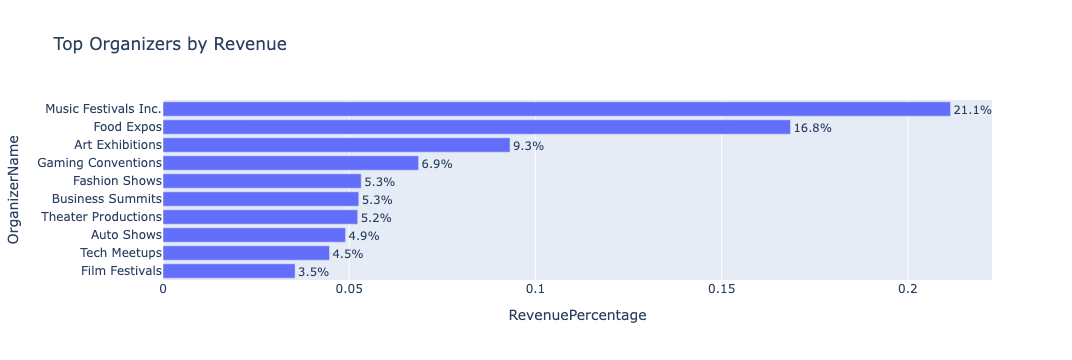

In [302]:
# SQL Query
organizer_revenue_query = """
WITH
    organizer_sales AS (
        SELECT 
            O.OrganizerName,
            SUM(P.Amount) AS TotalRevenue
        FROM Payment P
        INNER JOIN Booking B ON P.BookingID = B.BookingID
        INNER JOIN Event E ON B.EventID = E.EventID
        INNER JOIN Organizer O ON E.UserID = O.UserID
        GROUP BY O.OrganizerName
    )
SELECT
    OrganizerName,
    TotalRevenue,
    CAST(TotalRevenue AS FLOAT) / (SELECT SUM(TotalRevenue) FROM organizer_sales) AS RevenuePercentage
FROM organizer_sales
ORDER BY TotalRevenue DESC
LIMIT 10;
"""

# Fetch Data
organizer_revenue_df = run_query(organizer_revenue_query)

# Sort by Revenue
organizer_revenue_df.sort_values("TotalRevenue", inplace=True)

# Create Horizontal Bar Chart
organizer_revenue_plot = px.bar(
    organizer_revenue_df,
    x="RevenuePercentage",
    y="OrganizerName",
    orientation="h",
    text="RevenuePercentage",
    title="Top Organizers by Revenue",
)

# Format text labels
organizer_revenue_plot.update_traces(texttemplate="%{text:.1%}", textposition="outside")

# Show Chart
organizer_revenue_plot.show()

#### - Payment Method Analysis: 
A bar chart displaying the distribution of payment methods such as Credit Card, Cash, Bank Transfer, and PayPal.

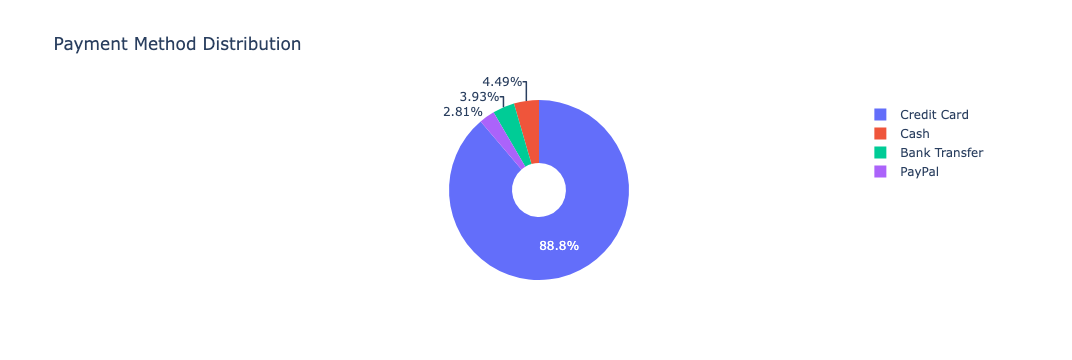

In [304]:
# SQL Query to Fetch Payment Method Distribution
payment_method_distribution_query = """
SELECT 
    PaymentMethod,
    COUNT(PaymentID) AS TransactionCount
FROM Payment
GROUP BY PaymentMethod
ORDER BY TransactionCount DESC;
"""

# Fetch Data from Database
payment_df = run_query(payment_method_distribution_query)

# Create Pie Chart using Plotly Express
payment_fig_pie = px.pie(
    payment_df,
    names="PaymentMethod",
    values="TransactionCount",
    title="Payment Method Distribution",
    hole=0.3  # For a donut-style chart
)

# Show Pie Chart
payment_fig_pie.show()


#### - Discount Source Usage Data: 
Shows the usage count of discounts from sources like Groupon, Company promotions, etc.

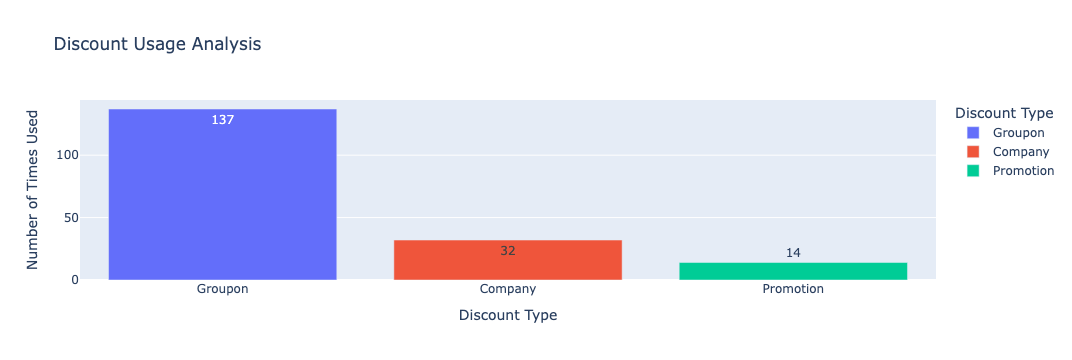

In [306]:
# SQL Query to Fetch Discount Usage Data
discount_usage_query = """
SELECT 
    d.DiscountSource,
    COUNT(b.DiscountID) AS UsageCount,
    SUM(b.TotalPrice) AS RevenueImpact
FROM Booking b
JOIN Discount d ON b.DiscountID = d.DiscountID
GROUP BY d.DiscountSource
ORDER BY UsageCount DESC;

"""

# Fetch Data
discount_df = run_query(discount_usage_query)

# Create Bar Chart using Plotly Express
discount_fig_bar = px.bar(
    discount_df,
    x="DiscountSource",
    y="UsageCount",
    title="Discount Usage Analysis",
    labels={"DiscountSource": "Discount Type", "UsageCount": "Number of Times Used"},
    text="UsageCount",
    color="DiscountSource"
)

# Show Bar Chart
discount_fig_bar.show()

#### - Heatmap for Venue Performance: 
A visual representation of venue utilization rates, indicating how well venues are being utilized.

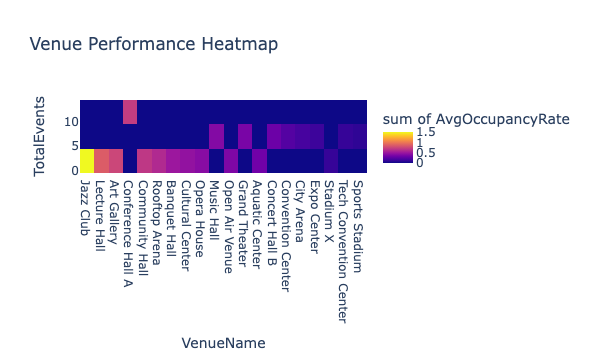

In [334]:
# SQL Query to Fetch Venue Utilization Data
venue_utilization_query = """
SELECT 
    v.VenueName,
    COUNT(ev.EventID) AS TotalEvents,
    ROUND((SUM(bs.SeatCount) / (COUNT(ev.EventID) * v.Capacity)) * 100, 2) AS AvgOccupancyRate
FROM Venue v
JOIN EventVenue ev ON v.VenueID = ev.VenueID
JOIN Event e ON ev.EventID = e.EventID
LEFT JOIN (
    SELECT b.EventID, COUNT(bs.SeatID) AS SeatCount
    FROM BookingSeat bs
    JOIN Booking b ON bs.BookingID = b.BookingID
    GROUP BY b.EventID
) bs ON e.EventID = bs.EventID
GROUP BY v.VenueName, v.Capacity
ORDER BY AvgOccupancyRate DESC;
"""

# Fetch Data
venue_df = run_query(venue_utilization_query)

venue_fig_heatmap = px.density_heatmap(
    venue_df,
    x="VenueName",
    y="TotalEvents",
    z="AvgOccupancyRate",
    title="Venue Performance Heatmap"
)

venue_fig_heatmap.show()



In [336]:
# Dashboard with datapane
report = dp.Report(
    dp.Text("# Ticket Reservation Insights Dashboard"),

    # Section 1: Key Performance Indicators (KPIs)
    dp.Group(
        dp.BigNumber(heading="Total Revenue", value=f"${total_revenue:,.2f}"),
        dp.BigNumber(heading="Total Bookings", value=total_bookings),
        dp.BigNumber(heading="Total Customers", value=total_customers),
        columns=3
    ),

    dp.Text("### Upcoming Five Events"),
    dp.Table(upcoming_event_df),

    # Section 2: Revenue Analytics
    dp.Text("## Revenue Analytics"),
    dp.Group(
        dp.Plot(revenue_by_event_plot, caption="Revenue by Event"),
        dp.Table(top_venue_df, caption="Top Revenue-Generating Venues"),
        columns=2
    ),
    dp.Plot(revenue_by_month_plot, caption="Monthly Revenue Growth Analysis"),

    # Section 3: Customer Behavior & Sales Analysis
    dp.Text("## Customer Behavior & Sales Analysis"),
    dp.Group(
        dp.Plot(sales_fig_bar, caption="Ticket Sales by Seat Category"),
        dp.Plot(user_fig_pie, caption="User Type Distribution"),
        columns=2
    ),
    dp.Group(
        dp.Plot(organizer_revenue_plot, caption="Top Organizers by Revenue Percentage"),
        dp.Plot(payment_fig_pie, caption="Payment Method Analysis"),
        columns=2
    ),
    dp.Plot(discount_fig_bar, caption="Discount Source Usage Data"),

    # Section 4: Venue Performance
    dp.Text("## Venue Performance"),
    dp.Plot(venue_fig_heatmap, caption="Heatmap for Venue Performance", responsive=True)
)

# Save the report
report.save(path="ticket_reservation_insights_dashboard.html")


App saved to ./ticket_reservation_insights_dashboard.html

In [332]:
report